# DIVA-WOA comparison
Plotting the comparison between World Ocean Atlas (WOA) 2018 products and the climatologies created with `DIVAnd`.
1. Horizontal maps
2. Vertical sections

In [3]:
import os
import glob
import netCDF4
import logging
import numpy as np
import cmocean
import calendar
import emodnetchemistry
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import calendar
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
plt.rcParams.update({'font.size': 16})
plt.rc('figure', facecolor='w')
from importlib import reload
reload(emodnetchemistry)

<module 'emodnetchemistry' from '/home/ctroupin/Projects/EMODnet/Chemistry3/EMODnet-Chemistry/python/emodnetchemistry.py'>

In [4]:
logger = logging.getLogger("EMODnet-Chemistry-WOA-DIVA")
logger.setLevel(logging.DEBUG)
logging.info("Starting")

### Variable

In [44]:
varname = "phosphate"
#varname = "ammonium"
#varname = "silicate"

In [49]:
varnamedict = {
    "phosphate": {
        "stdname": "moles_of_phosphate_per_unit_mass_in_sea_water",
        "units": "umol/l",
        "woaname": "p",
        "varmin": 0.,
        "varmax": 2.,
        "deltavar": 0.25 
    },
    "ammonium": {
        "stdname": "mole_concentration_of_ammonium_in_sea_water", 
        "units": "umol/l"
    }, 
    "oxygen": {
        "stdname": "mole_concentration_of_dissolved_molecular_oxygen_in_sea_water", 
        "units": "umol/l"
    },
    "silicate": {
        "stdname": "mole_concentration_of_silicate_in_sea_water", 
        "units": "$\mu$moles/l",
        "woaname": "i",
        "varmin": 0.,
        "varmax": 5.,
        "deltavar": 0.5 
    }, 
    "nitrogen": {
        "stdname": "mole_concentration_of_dissolved_inorganic_nitrogen_in_sea_water", 
        "units": "umol/l"
    },
    "chlorophyll": {
        "stdname": "mass_concentration_of_chlorophyll_in_sea_water", 
        "units": "mg/m^3"
    }
}

### Paths

In [43]:
#figdir = "f/home/ctroupin/dox/EMODnet-Chemistry/WOA-DIVA/{varname}/year/"
#figdirmonth = f"/home/ctroupin/dox/EMODnet-Chemistry/WOA-DIVA/{varname}/monthly/"

casename = "Water body phosphate-res-0.5-epsilon2-1.0-varlen0-maxit-100-monthly"
figdirmonth = f"/data/EMODnet/Eutrophication/figures/WOA-DIVA/{casename}/monthly/"


woabasedir = "https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/"
woavarinitial = varnamedict[varname]["woaname"]
woadataurl = f"{woabasedir}{varname}/all/1.00/woa18_all_{woavarinitial}00_01.nc"
logger.info(woadataurl)

#divafile = "/data/EMODnet/Eutrophication/Products/Results-0.1/Water body dissolved oxygen concentration_background_test_it2000_800km.nc"
#divafile = "/data/EMODnet/Eutrophication/Products/Water body dissolved oxygen concentration-res-0.1-epsilon2-1.0-lenx-800000.0-maxit-2000/Water body dissolved oxygen concentration_background.nc"
#divafile = "/data/EMODnet/Eutrophication/Products/Water body dissolved oxygen concentration-res-0.25-epsilon2-1.0-lenx-250000.0-maxit-100-monthly/Results/Water body dissolved oxygen concentration_monthly.nc"
#divafile = "/data/EMODnet/Eutrophication/Products/Water body phosphate-res-0.25-epsilon2-1.0-lenx-250000.0-maxit-100-monthly/Results/Water body phosphate_monthly.nc"
#divafile = "/data/EMODnet/Eutrophication/Products/Water body silicate-res-0.25-epsilon2-1.0-varlen0-maxit-100-monthly/Results/Water body silicate_monthly.nc"
divafile = f"/data/EMODnet/Eutrophication/Products/{casename}/Results/Water body phosphate_monthly.nc"

if not os.path.isdir(figdir):
    os.makedirs(figdir)
if not os.path.isdir(figdirmonth):
    os.makedirs(figdirmonth)
if not os.path.exists(divafile):
    logger.warning("DIVA file does not exist, check path")

INFO:EMODnet-Chemistry-WOA-DIVA:https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/silicate/all/1.00/woa18_all_i00_01.nc


In [6]:
domain = [-45., 70., 24., 83.]

### Initiate projection

In [7]:
m = Basemap(projection='merc', llcrnrlon=domain[0], llcrnrlat=domain[2],
            urcrnrlon=domain[1], urcrnrlat=domain[3],
            lat_ts=0.5 * (domain[2] + domain[3]), resolution='i')

## Reading data from the 2 products

In [12]:
logger.info("Reading fields from WOA")
lon_woa, lat_woa, depth_woa, time_woa, field_woa, = emodnetchemistry.read_variable_woa(woadataurl, domain)
logger.info("Found {} depth levels".format(len(depth_woa)))

logger.info("Reading fields from DIVAnd")
lon_diva, lat_diva, depth_diva, time_diva, field_diva = emodnetchemistry.read_variable_diva(divafile, domain, timeindex=1)
logger.info("Found {} depth levels".format(len(depth_diva)))
llon_woa, llat_woa = np.meshgrid(lon_woa, lat_woa)
llon_diva, llat_diva = np.meshgrid(lon_diva, lat_diva)

INFO:EMODnet-Chemistry-WOA-DIVA:Reading fields from WOA
INFO:EMODnet-Chemistry-Data-positions:Variable name: i_an
INFO:EMODnet-Chemistry-Data-positions:Standard name: moles_concentration_of_silicate_in_sea_water
INFO:EMODnet-Chemistry-WOA-DIVA:Found 102 depth levels


## Loop on the depths

In [76]:
for index2, d2 in enumerate(depth2[-2:]):
    logger.info("Working on depth {}".format(d2))
    index1 = np.where(depth1 == d2)[0][0]

    depthstring = str(int(d2)).zfill(4))
    figname = os.path.join(figdir, f"{varname}_DIVAnd_WOA_year_{depthstring}.jpg")
    emodnetchemistry.plot_WOA_DIVAnd_comparison(m, 
                                                llon_woa, llat_woa, field_woa[index1,:,:], 
                                                llon_diva, llat_diva, field_diva[index2,:,:], 
                                                d2, figname=figname, 
                                                vmin=varnamedict[varname]["vmin"], 
                                                vmax=varnamedict[varname]["vmax"], 
                                                deltavar=deltvarnamedict[varname]["deltavar"],
                                                units=varunits)

INFO:EMODnet-Chemistry-WOA-DIVA:Working on depth 5000.0
INFO:EMODnet-Chemistry-WOA-DIVA:Working on depth 5500.0


## Monthly
We loop on the months, so the URL of the WOA file will be different.

In [51]:
depthlist2plot = [0, 10, 50, 100, 250., 500., 750., 1000., 2000.]
for month in range(1, 13):
    mm = str(month).zfill(2)
    logger.info(f"Working on month {calendar.month_name[month]}")
    
    woavarinitial = varnamedict[varname]["woaname"]
    woadataurl = f"{woabasedir}{varname}/all/1.00/woa18_all_{woavarinitial}{mm}_01.nc"
    logger.info("WOA file URL:")
    logger.info(woadataurl)
    
    logger.info("Reading fields from WOA")
    lon_woa, lat_woa, depth_woa, time_woa, field_woa, = emodnetchemistry.read_variable_woa(woadataurl, domain)
    logger.info("Found {} depth levels".format(len(depth_woa)))
    logger.info(time_woa)
    
    logger.info("Reading fields from DIVAnd")
    lon_diva, lat_diva, depth_diva, date_diva, field_diva = emodnetchemistry.read_variable_diva(divafile, domain, 
                                                                       timeindex=month-1)
    logger.info("Found {} depth levels".format(len(depth_diva)))
    logger.info(date_diva)
    
    llon_woa, llat_woa = np.meshgrid(lon_woa, lat_woa)
    llon_diva, llat_diva = np.meshgrid(lon_diva, lat_diva)
    
    # Loop on depths:
    # (depths are expected to be the same for the 2 products)
    
    for depth in depthlist2plot:
        logger.info("Working on depth {}".format(depth))
        
        try:
            index1 = np.where(depth_woa == depth)[0][0]
        except IndexError:
            logger.info("Depth {} not found in WOA; exiting loop\n".format(depth))
            break
            
        index2 = np.where(depth_diva == depth)[0][0]
        
        dd = str(int(depth)).zfill(4)
    
        logger.debug(f"index1 = {index1}, index2 = {index2}")
        figname = os.path.join(figdirmonth, f"{varname}_DIVAnd_WOA_month_{mm}_{dd}.jpg")
        emodnetchemistry.plot_WOA_DIVAnd_comparison(m, llon_woa, llat_woa, field_woa[index1,:,:], 
                                                llon_diva, llat_diva, field_diva[index2,:,:], 
                                                depth, figname=figname, 
                                                vmin=varnamedict[varname]["varmin"], 
                                                vmax=varnamedict[varname]["varmax"], 
                                                deltavar=varnamedict[varname]["deltavar"],
                                                units=r"{} concentration ({})".format(varname.capitalize(), varnamedict[varname]["units"]),
                                                monthname=calendar.month_name[month])

INFO:EMODnet-Chemistry-WOA-DIVA:Working on month January
INFO:EMODnet-Chemistry-WOA-DIVA:WOA file URL:
INFO:EMODnet-Chemistry-WOA-DIVA:https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/phosphate/all/1.00/woa18_all_p01_01.nc
INFO:EMODnet-Chemistry-WOA-DIVA:Reading fields from WOA
INFO:EMODnet-Chemistry-Data-positions:Variable name: p_an
INFO:EMODnet-Chemistry-Data-positions:Standard name: moles_concentration_of_phosphate_in_sea_water
INFO:EMODnet-Chemistry-WOA-DIVA:Found 43 depth levels
INFO:EMODnet-Chemistry-WOA-DIVA:[696.5]
INFO:EMODnet-Chemistry-WOA-DIVA:Reading fields from DIVAnd
INFO:EMODnet-Chemistry-Data-positions:Variable name: Water body phosphate
INFO:EMODnet-Chemistry-Data-positions:Long name: Water body phosphate
INFO:EMODnet-Chemistry-WOA-DIVA:Found 102 depth levels
INFO:EMODnet-Chemistry-WOA-DIVA:1995-01-16 00:00:00
INFO:EMODnet-Chemistry-WOA-DIVA:Working on depth 0
DEBUG:EMODnet-Chemistry-WOA-DIVA:index1 = 0, index2 = 0
INFO:EMODnet-Chemistry-WOA-DIVA:Working on dept

DEBUG:EMODnet-Chemistry-WOA-DIVA:index1 = 20, index2 = 20
INFO:EMODnet-Chemistry-WOA-DIVA:Working on depth 250.0
DEBUG:EMODnet-Chemistry-WOA-DIVA:index1 = 26, index2 = 26
INFO:EMODnet-Chemistry-WOA-DIVA:Working on depth 500.0
DEBUG:EMODnet-Chemistry-WOA-DIVA:index1 = 36, index2 = 36
INFO:EMODnet-Chemistry-WOA-DIVA:Working on depth 750.0
DEBUG:EMODnet-Chemistry-WOA-DIVA:index1 = 41, index2 = 41
INFO:EMODnet-Chemistry-WOA-DIVA:Working on depth 1000.0
INFO:EMODnet-Chemistry-WOA-DIVA:Depth 1000.0 not found in WOA; exiting loop

INFO:EMODnet-Chemistry-WOA-DIVA:Working on month June
INFO:EMODnet-Chemistry-WOA-DIVA:WOA file URL:
INFO:EMODnet-Chemistry-WOA-DIVA:https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/phosphate/all/1.00/woa18_all_p06_01.nc
INFO:EMODnet-Chemistry-WOA-DIVA:Reading fields from WOA
INFO:EMODnet-Chemistry-Data-positions:Variable name: p_an
INFO:EMODnet-Chemistry-Data-positions:Standard name: moles_concentration_of_phosphate_in_sea_water
INFO:EMODnet-Chemistry-WOA-DIVA

INFO:EMODnet-Chemistry-Data-positions:Long name: Water body phosphate
INFO:EMODnet-Chemistry-WOA-DIVA:Found 102 depth levels
INFO:EMODnet-Chemistry-WOA-DIVA:1995-10-16 00:00:00
INFO:EMODnet-Chemistry-WOA-DIVA:Working on depth 0
DEBUG:EMODnet-Chemistry-WOA-DIVA:index1 = 0, index2 = 0
INFO:EMODnet-Chemistry-WOA-DIVA:Working on depth 10
DEBUG:EMODnet-Chemistry-WOA-DIVA:index1 = 2, index2 = 2
INFO:EMODnet-Chemistry-WOA-DIVA:Working on depth 50
DEBUG:EMODnet-Chemistry-WOA-DIVA:index1 = 10, index2 = 10
INFO:EMODnet-Chemistry-WOA-DIVA:Working on depth 100
DEBUG:EMODnet-Chemistry-WOA-DIVA:index1 = 20, index2 = 20
INFO:EMODnet-Chemistry-WOA-DIVA:Working on depth 250.0
DEBUG:EMODnet-Chemistry-WOA-DIVA:index1 = 26, index2 = 26
INFO:EMODnet-Chemistry-WOA-DIVA:Working on depth 500.0
DEBUG:EMODnet-Chemistry-WOA-DIVA:index1 = 36, index2 = 36
INFO:EMODnet-Chemistry-WOA-DIVA:Working on depth 750.0
DEBUG:EMODnet-Chemistry-WOA-DIVA:index1 = 41, index2 = 41
INFO:EMODnet-Chemistry-WOA-DIVA:Working on depth

## Vertical sections
### Meridional section

In [57]:
lonsection = -12.5
lonsel1 = np.where(lon1 == lonsection)[0][0]
lonsel2 = np.where(lon2 == lonsection)[0][0]

325

In [95]:
oxy_section1 = oxy1[:,:,lonsel1]
oxy_section2 = oxy2[:,:,lonsel2]
vmin = 200.
vmax = 400.
deltavar = 25.
units = r"$\mu$moles/kg"
figdir = "/home/ctroupin/dox/EMODnet-Chemistry/Sections/"
if not os.path.exists(figdir):
    os.mkdir(figdir)

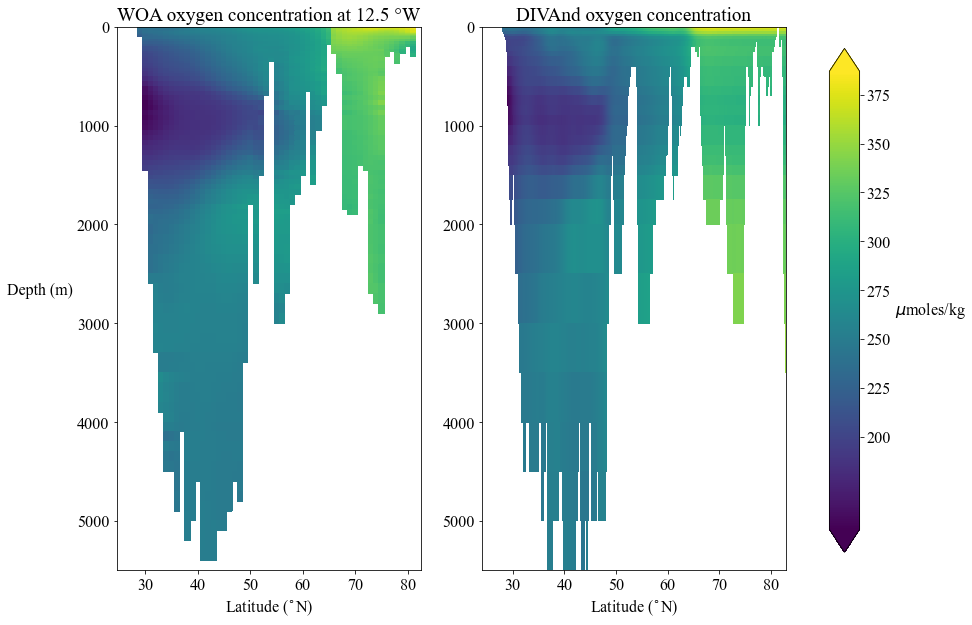

In [97]:
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot(121)
pcm = plt.pcolormesh(lat1, depth1, oxy_section1)
plt.ylabel("Depth (m)", rotation=0, ha="right")
plt.xlabel("Latitude ($^{\circ}$N)")
plt.title(f"WOA oxygen concentration at {abs(lonsection)} °W")
ax1.invert_yaxis()

ax2 = plt.subplot(122)
pcm = plt.pcolormesh(lat2, depth2, oxy_section2)
plt.xlabel("Latitude ($^{\circ}$N)")
plt.title(f"DIVAnd oxygen concentration")

ax2.invert_yaxis()


cbar_ax = fig.add_axes([0.95, 0.15, 0.035, 0.7])
cb = plt.colorbar(pcm,  cax=cbar_ax, extend="both", orientation="vertical")
cb.set_label(units, rotation=0, ha="left")
cb.set_ticks(np.arange(vmin, vmax + 0.0001, deltavar))


if figname is not None:
    plt.savefig(os.path.join(figdir, "oxygen_section_12pt5W"), dpi=300, bbox_inches="tight")
# plt.show()
plt.close()

### Zonal section

In [100]:
latsection = 72.5
latsel1 = np.where(lat1 == latsection)[0][0]
latsel2 = np.where(lat2 == latsection)[0][0]

In [101]:
oxy_section1 = oxy1[:,latsel1,:]
oxy_section2 = oxy2[:,latsel2,:]

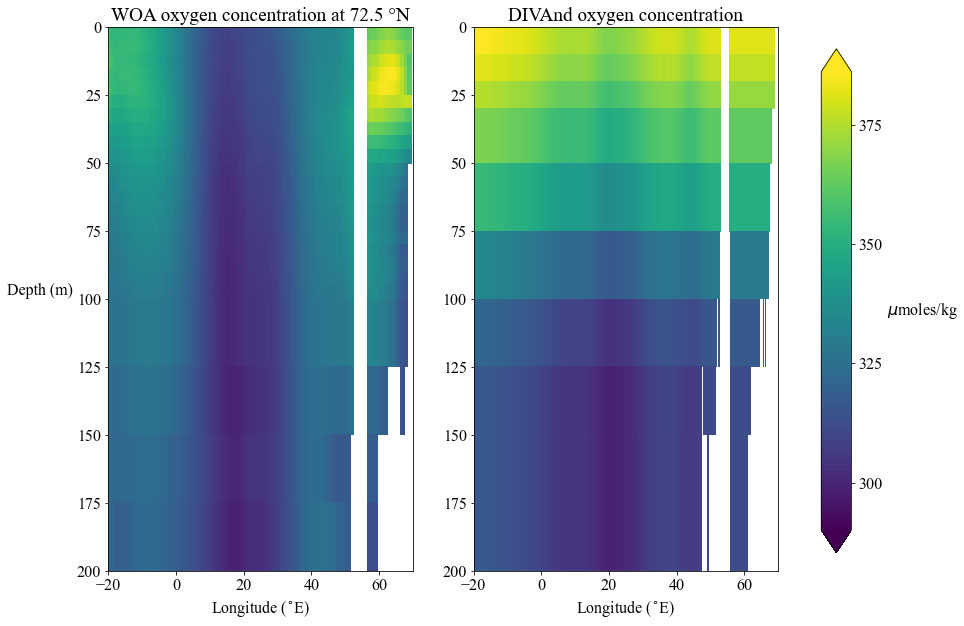

In [110]:
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot(121)
pcm = plt.pcolormesh(lon1, depth1, oxy_section1)
plt.ylabel("Depth (m)", rotation=0, ha="right")
plt.xlabel("Longitude ($^{\circ}$E)")
plt.title(f"WOA oxygen concentration at {abs(latsection)} °N")
ax1.set_ylim(0., 200.)
ax1.set_xlim(-20., 70.)

ax1.invert_yaxis()

ax2 = plt.subplot(122)
pcm = plt.pcolormesh(lon2, depth2, oxy_section2)
plt.xlabel("Longitude ($^{\circ}$E)")
plt.title(f"DIVAnd oxygen concentration")
ax2.set_ylim(0., 200.)
ax2.set_xlim(-20., 70.)

ax2.invert_yaxis()

cbar_ax = fig.add_axes([0.95, 0.15, 0.035, 0.7])
cb = plt.colorbar(pcm,  cax=cbar_ax, extend="both", orientation="vertical")
cb.set_label(units, rotation=0, ha="left")
cb.set_ticks(np.arange(vmin, vmax + 0.0001, deltavar))


plt.savefig(os.path.join(figdir, "oxygen_section_72pt5N_zoom"), dpi=300, bbox_inches="tight")
# plt.show()
plt.close()